In [9]:
import argparse
from datahandler import DataHandler
from config import Config
import tensorflow as tf
from models import CRNN as Model
from models import input_fn
from shutil import rmtree
from os import listdir
import os

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

In [18]:
cf = Config('r-c-shhs',#c-simulated',
                'cluster',
                'revised-shallow',
                None).get_configs(cross_validate=None)


DataHandler.setup_partitions(config=cf,
                             model_memory=False,
                             cross_validate=None)

Removing existing model: /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow/


In [19]:
tf.logging.set_verbosity(tf.logging.INFO)
run_config = tf.estimator.RunConfig(save_checkpoints_steps=cf.eparams.save_checkpoint_steps,
                                    save_summary_steps=cf.eparams.save_summary_steps)
model = Model('CRNN', cf.eparams)
classifier = tf.estimator.Estimator(
        model_fn=lambda features, labels, mode: model(features, labels, mode, cf.hparams),
        model_dir=cf.eparams.ckptdir,
        config=run_config)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb1e51bef10>, '_evaluation_master': '', '_save_checkpoints_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow/', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [ ]:
train_spec = tf.estimator.TrainSpec(input_fn=lambda: input_fn('train', cf.eparams),
                                            max_steps=cf.eparams.train_steps,
                                            hooks=[])
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: input_fn('val', cf.eparams),
                                  steps=cf.eparams.eval_steps,
                                  throttle_secs=cf.eparams.throttle_secs,
                                  hooks=[])
tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 360 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
X: (?, 2, 60, 1, 625)
conv_block_1/conv1: (?, 32, 60, 1, 618)
conv_block_1/conv2: (?, 32, 60, 1, 611)
conv_block_1/pool: (?, 32, 60, 1, 303)
conv_block_2/conv1: (?, 64, 60, 1, 296)
conv_block_2/conv2: (?, 64, 60, 1, 289)
conv_block_2/pool: (?, 64, 60, 1, 142)
conv_block_3/conv1: (?, 128, 60, 1, 135)
conv_block_3/conv2: (?, 128, 60, 1, 128)
conv_block_3/pool: (?, 128, 60, 1, 62)
rnn_input: (?, 60, 7936)
rnn_output: (?, 60, 128)
dense_input: (?, 60, 128)
INFO:tensorflow:Scale of 0 disables regularizer.
network output: (?, 60, 128)
logits: (?, 2)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:global_step/sec: 3.22892
INFO:tensorflow:loss = 3.56887, step = 1101 (30.969 sec)
INFO:tensorflow:Mode: train, Step: 1101, loss: 3.5689, accuracy: 0.75
INFO:tensorflow:Mode: train, Step: 1126, loss: 3.5321, accuracy: 0.88
INFO:tensorflow:Mode: train, Step: 1151, loss: 3.5251, accuracy: 0.62
INFO:tensorflow:Mode: train, Step: 1176, loss: 3.3755, accuracy: 0.88
INFO:tensorflow:Saving checkpoints for 1184 into /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow/model.ckpt.
INFO:tensorflow:Loss for final step: 3.48374.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-09-00:44:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow/model.ckpt-1184
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [20/200

In [5]:
from __future__ import division
from os import listdir
import utils
import h5py
import numpy as np
import pandas as pd
import os
import sys

# todo: implement rejection of noise epochs
debugging = False
multimodal = False
simulated_data = False
revised_preprocessing = True
rescale_mode = 'soft'
cohort = 'SHHS-Sherlock-matched'
#cohort = 'Simulated-Sherlock'

if cohort == 'SSC':
    edf_folder = '/home/rasmus/Desktop/SSC/raw/edf/'
    hypnogram_folder = '/home/rasmus/Desktop/SSC/raw/hypnograms/'
    epoch_duration = 5
    channels_to_load = {'C3': 0, 'C4': 1, 'Fz': 2, 'ROC': 3, 'LOC': 4, 'Chin': 5}
    output_folder = '/home/rasmus/Desktop/SSC/processed_data/'
    IDs = listdir(edf_folder)
    channel_alias = utils.read_channel_alias(edf_folder+'signal_labels.json')
elif cohort == 'SHHS-Sherlock':
    epoch_duration = 5*60
    edf_folder = '/scratch/PI/mignot/nsrr/shhs/polysomnography/edfs/shhs1/'
    hypnogram_folder = None
    df = pd.read_csv('/home/users/rmth/stroke-deep-learning/IDs.csv')
    IDs = np.asarray(df['IDs'])
    group = np.asarray(df['group'])
    if multimodal:
        channels_to_load = {'eeg1': 0, 'eeg2': 1, 'ecg': 2, 'pulse': 3}
        output_folder = '/scratch/users/rmth/processed_shhs_data_multimodal/'
        channel_alias = utils.read_channel_alias(output_folder+'signal_labels_multimodal.json')
    else:
        channels_to_load = {'eeg1': 0, 'eeg2': 1}
        if revised_preprocessing:
            output_folder = '/scratch/users/rmth/processed_shhs_data_revised/'
        else:
            output_folder = '/scratch/users/rmth/processed_shhs_data/'
        channel_alias = utils.read_channel_alias(output_folder+'signal_labels.json')
elif cohort == 'SHHS-Sherlock-matched':
    epoch_duration = 5*60
    edf_folder = '/scratch/PI/mignot/nsrr/shhs/polysomnography/edfs/shhs1/'
    hypnogram_folder = None
    df = pd.read_csv('/home/users/rmth/stroke-deep-learning/matched_controls.csv')
    IDs = np.asarray(df['conIDs'])
    group = np.asarray(np.zeros(len(IDs)))
    if multimodal:
        channels_to_load = {'eeg1': 0, 'eeg2': 1, 'ecg': 2, 'pulse': 3}
        output_folder = '/scratch/users/rmth/processed_shhs_data_multimodal/'
        channel_alias = utils.read_channel_alias(output_folder+'signal_labels_multimodal.json')
    else:
        channels_to_load = {'eeg1': 0, 'eeg2': 1}
        if revised_preprocessing:
            output_folder = '/scratch/users/rmth/processed_shhs_data_revised/matched_controls/'
        else:
            output_folder = '/scratch/users/rmth/processed_shhs_data_matched/'
        channel_alias = utils.read_channel_alias(output_folder+'signal_labels.json')
elif cohort == 'SHHS':
    epoch_duration = 5*60
    edf_folder = '/home/rasmus/Desktop/shhs_subset/'
    hypnogram_folder = None
    control = listdir(edf_folder + 'control')
    stroke = listdir(edf_folder + 'stroke')
    if debugging:
        control = control[0:1]
        stroke = stroke[0:1]
    group = np.concatenate((np.zeros(shape=len(control)),
                            np.ones(shape= len(stroke))))
    IDs = control+stroke
    if multimodal:
        channels_to_load = {'eeg1': 0, 'eeg2': 1, 'ecg': 2, 'pulse': 3}
        output_folder = '/home/rasmus/Desktop/shhs_subset/processed_data_multimodal/'
        channel_alias = utils.read_channel_alias(edf_folder+'signal_labels_multimodal.json')
    elif simulated_data:
        output_folder = '/home/rasmus/Desktop/shhs_subset/simulated_data/'
    else:
        channels_to_load = {'eeg1': 0, 'eeg2': 1}
        output_folder = '/home/rasmus/Desktop/shhs_subset/processed_data/'
        channel_alias = utils.read_channel_alias(edf_folder+'signal_labels.json')
elif cohort == 'Simulated-Sherlock':
    epoch_duration = 5*60
    edf_folder = '/scratch/PI/mignot/nsrr/shhs/polysomnography/edfs/shhs1/'
    hypnogram_folder = None
    df = pd.read_csv('/home/users/rmth/stroke-deep-learning/IDs.csv')
    IDs = np.asarray(df['IDs'])
    group = np.asarray(df['group'])
    channels_to_load = {'eeg1': 0, 'eeg2': 1}
    output_folder = '/scratch/users/rmth/simulated_data/'
    channel_alias = utils.read_channel_alias(output_folder+'signal_labels.json')

In [6]:
from scipy.signal import butter, sosfilt, welch
from scipy.interpolate import interp1d

def determine_artefact_segments(x, fs, window_size, factors):   
    f, t, Sxx = signal.spectrogram(x, fs, nperseg=window_size, noverlap=0)
    ratio_high_frequency = np.sum(Sxx[f > 45,:],axis=0) / np.sum(Sxx[f < 20,:],axis=0)
    power_high_frequency = np.sum(Sxx[f > 45,:],axis=0)
    cond_ratio = ratio_high_frequency > np.min(ratio_high_frequency)*factors[0]
    cond_power = power_high_frequency > np.min(power_high_frequency)*factors[1]
    cond = cond_ratio+cond_power
    artefact_idx = cond != 0
    return t, artefact_idx

def remove_artefacts(x, fs):
    window_length=5
    window_size = int(5*fs)
    indices = []
    tt = np.arange(0, x.shape[1]//fs,1/fs)
    for i in range(x.shape[0]):
        t,idx = determine_artefact_segments(np.squeeze(x[i,:]), fs, window_size,factors=[1e2,1e2])
        f = interp1d(t, idx,'nearest', fill_value='extrapolate')
        indices.append(f(tt).tolist())
    i = np.sum(np.stack(indices),axis=0) == 0
    return x[:,i]

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

In [7]:
if simulated_data:
    flag = 0
    n_records = 0
    n_records_per_class = 20
import matplotlib.pyplot as plt
from scipy import signal
#fig, ax = plt.subplots(nrows=2, ncols=2)
for counter, ID in enumerate(IDs):
    #if counter != 0:
    #    continue
    if simulated_data:
        if flag == 0:
            if int(group[counter]) == 1:
                continue
            else:
                n_records += 1
                if n_records == n_records_per_class:
                    flag = 1
                    n_records = 0
        elif flag == 1:
            if int(group[counter]) == 0:
                continue
            else:
                n_records += 1
                if n_records == n_records_per_class:
                    flag = 2
                    n_records = 0
        elif flag == 2:
            break
    
    try:
        #if ID != 202345: # Different sampling frequency
        #    continue
        #if counter != 3:
        #    continue
            
        print('Processing: ' + str(ID) + ' (number ' + str(counter+1) + ' of ' + str(len(IDs)) + ').')
        if cohort == 'SSC':
            filename = edf_folder + ID
        elif cohort == 'SHHS-Sherlock' or cohort == 'SHHS-Sherlock-matched' or cohort == 'Simulated-Sherlock':
            filename = edf_folder + 'shhs1-' + str(int(ID)) + '.edf'
        elif cohort == 'SHHS':
            if group[counter] == 1:
                filename = edf_folder + 'stroke/' + ID
            else:
                filename = edf_folder + 'control/' + ID

        try:
            data = utils.load_edf_file(filename, channels_to_load,
                                       cohort = cohort,
                                       channel_alias = channel_alias)
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)
            print(e)
            print('    EDF error (loading failed).')
            continue
        if data == -1:
            print('    Ignoring this subject due to different header setup.')
            continue

        z = remove_artefacts(data['x'],data['fs'])
        x = butter_bandpass_filter(z, .3, 40, data['fs'], order=32)
        
        n = x.shape[1]
        epoch_samples = epoch_duration * data['fs']
        n_epochs = n // epoch_samples
        if hypnogram_folder:
            filename = hypnogram_folder + ID[:-4] + '.STA'
            try:
                hypnogram = utils.load_hypnogram_file(filename)
                if epoch_duration != 30:
                    hypnogram = np.repeat(hypnogram, repeats=30 // epoch_duration)
                if n != hypnogram.shape[0]:
                    hypnogram = hypnogram[:n_epochs]
            except:
                print('    Hypnogram error')
                continue

        epoched = np.zeros((int(len(channels_to_load)), int(n_epochs), int(epoch_samples)))
        for i in range(len(channels_to_load)):
            epoched[int(i), :, :] = np.asarray(list(zip(*[iter(x[int(i),:])] * int(epoch_samples))))

        #print(epoched.shape)
            
        if simulated_data:
            noise = np.random.normal(0, .25, epoched.shape)
            #if group[counter] == 1:
            #    x = utils.add_known_complex(x, data['fs'])
            noise_complex = utils.add_known_complex(noise, data['fs'], group = int(group[counter]))
            x = noise_complex #utils.rescale(x = noise_complex, fs=data['fs'], mode = rescale_mode)
            #ax[int(group[counter]),0].plot(x[0,0,:])
            #ax[int(group[counter]),1].plot(x[1,0,:])
            #ax[int(group[counter]),0].set_ylim([-5,5])
            #ax[int(group[counter]),1].set_ylim([-5,5])
        else:
            x = utils.rescale(epoched, data['fs'], rescale_mode)
            
        
        if cohort == 'SSC':
            stages_to_use = [5,2]
            stage_names = ['wake','n1','n2','n3','n4','rem','unknown','artefact']
            for group, stage in enumerate(stages_to_use):
                output_file_name = output_folder +  ID[:-4] + '_' + stage_names[stage] + ".hpf5"
                with h5py.File(output_file_name, "w") as f:
                    dset = f.create_dataset("x", data=x[:, hypnogram == stage, :], chunks=True)
                    f['fs'] = data['fs']
                    f["group"] = group
        elif cohort == 'SHHS-Sherlock' or cohort == 'SHHS-Sherlock-matched' or cohort == 'Simulated-Sherlock':
            output_file_name = output_folder + 'shhs1-' + str(ID) + ".hpf5"
            with h5py.File(output_file_name, "w") as f:
                dset = f.create_dataset('x', data=x, chunks=True)
                f['fs'] = data['fs']
                f['group'] = int(group[counter])
        elif cohort == 'SHHS':
            output_file_name = output_folder +  ID[:-4] + ".hpf5"
            with h5py.File(output_file_name, "w") as f:
                dset = f.create_dataset("x", data=x, chunks=True)
                f['fs'] = data['fs']
                f["group"] = group[counter]
        
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        print(e)
        print('Error happened while processing: {}'.format(str(filename)))

print("All files processed.")





Processing: 200294.0 (number 1 of 76).
Processing: 200298.0 (number 2 of 76).
Processing: 200299.0 (number 3 of 76).
Processing: 200325.0 (number 4 of 76).
Processing: 200379.0 (number 5 of 76).
Processing: 200401.0 (number 6 of 76).
Processing: 200416.0 (number 7 of 76).
Processing: 200450.0 (number 8 of 76).
Processing: 200510.0 (number 9 of 76).
Processing: 200600.0 (number 10 of 76).
Processing: 200677.0 (number 11 of 76).
Processing: 200696.0 (number 12 of 76).
Processing: 200789.0 (number 13 of 76).
Processing: 200941.0 (number 14 of 76).
Processing: 200950.0 (number 15 of 76).
Processing: 200965.0 (number 16 of 76).
Processing: 200969.0 (number 17 of 76).
Processing: 201115.0 (number 18 of 76).
(<type 'exceptions.IOError'>, '<ipython-input-7-ac982c0f2cda>', 51)
can not open file, no such file or directory
    EDF error (loading failed).
Processing: 201128.0 (number 19 of 76).
Processing: 201134.0 (number 20 of 76).
Processing: 201147.0 (number 21 of 76).
Processing: 201155.0 (nu

<IPython.core.display.Javascript object>


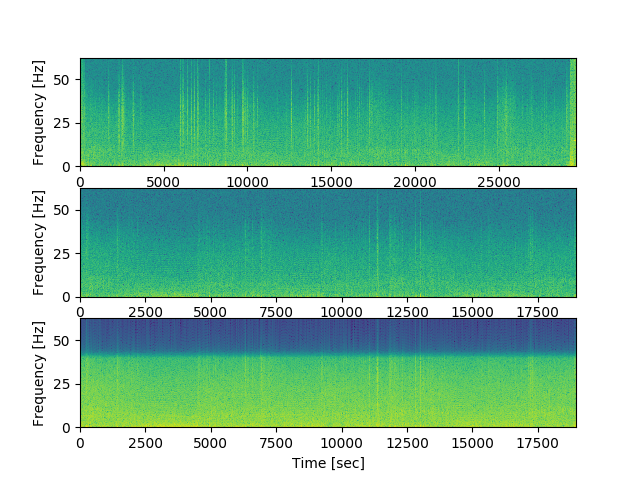

In [235]:
%matplotlib notebook
x = data['x']
fs = data['fs']
z = remove_artefacts(x,fs)
x_filtered = butter_bandpass_filter(z, .3, 40, fs, order=32)

print(x.shape)
print(z.shape)
print(x_filtered.shape)

x = x[0,:]
z = z[0,:]
x_filtered = x_filtered[0,:]

f, t, S = signal.spectrogram(x, fs, nperseg=int(5*fs), noverlap=0)
S = np.log(S)
plt.subplot(3,1,1)
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f, t, S = signal.spectrogram(z, fs, nperseg=int(5*fs), noverlap=0)
S = np.log(S)
plt.subplot(3,1,2)
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, S = signal.spectrogram(x_filtered, fs, nperseg=int(5*fs), noverlap=0)
S = np.log(S)
plt.subplot(3,1,3)
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()